In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import astropy.io.ascii as aa
import astropy.io.fits as af
import binned
import bisect
import emcee
import gzip
from matplotlib.colors import LogNorm
import os
import os.path as op
import plotutils.autocorr as ac
import plotutils.plotutils as pu
import plotutils.runner as pr
import scipy.integrate as sint
import scipy.interpolate as si
import scipy.optimize as so

Populating the interactive namespace from numpy and matplotlib


# Occurrence Rate Calculations (Binned)

In [2]:
hw_data_directory = '/Users/farr/Documents/Research/KepHackWeek/data'
occur_dir = '/Users/farr/Google Drive/Kepler ExoPop Hack 2015/end2end_occ_calc'
eff_dir = '/Volumes/KepHacWkWMF/Kepler_HW2015/Dp4_DetectionCountours/v0'

In [3]:
rbins = array([1.5**(i-1) for i in range(9)])
pbins = array([10*2**i for i in range(6)])
print rbins, pbins

[  0.66666667   1.           1.5          2.25         3.375        5.0625
   7.59375     11.390625    17.0859375 ] [ 10  20  40  80 160 320]


In [4]:
def integrate_efficiency(ps, rs, eff, pmin, pmax, rmin, rmax):
    sel = (ps >= pmin) & (ps < pmax)
    p_integral = sint.simps(eff[sel, :], ps[sel], axis=0)
    p_integral = p_integral / (np.max(ps[sel])-np.min(ps[sel]))
    sel = (rs >= rmin) & (rs < rmax)
    return sint.simps(p_integral[sel], rs[sel]) / (np.max(rs[sel]) - np.min(rs[sel]))

In [5]:
def rate_and_uncertainty(npl, nexpected):
    Rbest = npl / nexpected
    dr = sqrt(npl + 1) / nexpected
    
    Rmin = max(0.0, Rbest - 10*dr)
    Rmax = Rbest + 10*dr
    
    Rs = linspace(Rmin, Rmax, 10000)
    logpost = (npl-0.5)*log(Rs) - nexpected*Rs
    post = exp(logpost)
    post = post / trapz(post, Rs)
    cumpost = sint.cumtrapz(post, Rs)
    
    imin = argmin(abs(cumpost - 0.16))
    imed = argmin(abs(cumpost - 0.5))
    imax = argmin(abs(cumpost - 0.84))
    
    return Rs[imed], Rs[imin], Rs[imax]

## Planet Database

In [6]:
planets = aa.read(op.join(hw_data_directory, 'dr24_koi.csv'))
planets

kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,koi_gmag_err,koi_rmag,koi_rmag_err,koi_imag,koi_imag_err,koi_zmag,koi_zmag_err,koi_jmag,koi_jmag_err,koi_hmag,koi_hmag_err,koi_kmag,koi_kmag_err,koi_kepmag,koi_kepmag_err,koi_delivname,koi_vet_stat,koi_quarters,koi_disposition,koi_pdisposition,koi_count,koi_num_transits,koi_max_sngle_ev,koi_max_mult_ev,koi_bin_oedp_sig,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_trans_mod,koi_model_snr,koi_model_dof,koi_model_chisq,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_period,koi_period_err1,koi_period_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sage,koi_sage_err1,koi_sage_err2,koi_sparprov,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dicco_fra,koi_dicco_fra_err,koi_dicco_fdec,koi_dicco_fdec_err,koi_dicco_fsky,koi_dicco_fsky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,koi_dikco_fra,koi_dikco_fra_err,koi_dikco_fdec,koi_dikco_fdec_err,koi_dikco_fsky,koi_dikco_fsky_err,koi_comment,koi_vet_date,koi_tce_plnt_num,koi_tce_delivname,koi_datalink_dvs,koi_disp_prov,koi_parm_prov,koi_time0,koi_time0_err1,koi_time0_err2,koi_datalink_dvr,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype
int64,str9,str14,float64,float64,str12,float64,float64,str12,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,str15,str4,float64,str14,str14,int64,int64,float64,float64,int64,str33,float64,float64,float64,float64,str34,float64,int64,int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,str225,str10,int64,str15,str64,str15,str15,float64,float64,float64,str60,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,str4
7697568,K01829.01,--,296.52243,0.0,19h46m05.38s,43.363369,0.0,+43d21m48.1s,16.591,--,15.841,--,15.62,--,15.448,--,14.437,0.029,14.033,0.031,13.865,0.049,15.911,--,q1_q17_dr24_koi,Done,1.11111111111e+30,CANDIDATE,CANDIDATE,2,57,12.036085,50.30746,--,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2223,0.4689,Mandel and Agol (2002 ApJ 580 171),60.5,--,--,138.63416,0.00119,-0.00119,0,--,--,--,--,--,23.37,8.48,-1.93,0.1499,--,--,1.1845,0.5157,-0.1152,2.6837,0.0633,-0.0633,--,--,--,3390.3,71.2,-71.2,22.84151055,3.352e-05,-3.352e-05,0.260388,0.504439,-0.100065,28.03,6.5,-6.5,87.66,--,--,556.

## G Dwarfs

Load up the G-star table:

In [25]:
gdata = genfromtxt(op.join(occur_dir, 'hack_week_g_stars.csv'), delimiter=',', names=True)

We want to know the *average* detection efficiency across the bin.  (Actually, what we want to know is the fraction of the planets appearing in the bin that would be detected, but since we are assuming that the planet distribution function is flat, this reduces to the average.)

$$
\alpha_i \equiv \frac{1}{\Delta P \Delta R} \int dP\,dR\, p_{det}(P,R)
$$

For each of the Kep ID's in the G-star table, load up the efficiency contour, and calculate the efficiency integrated over the relevant bin limits.  Save a two-column ``kepid`` and ``alpha`` file.  There are lots of errors because there are a number of stars that pass our cuts that do not have efficiency calculations from Chris---I think these are the un-classified stars that have $T$ and $log(g)$ replaced with solar values.

In [27]:
with gzip.open('g-integrated-eff.dat.gz.temp', 'w') as out:
    out.write('# kepid ')
    out.write(' '.join(['(%g-%g, %g-%g)'%(plow, phigh, rlow, rhigh) \
                        for (plow, phigh) in zip(pbins[:-1], pbins[1:]) \
                        for (rlow, rhigh) in zip(rbins[:-1], rbins[1:])]))
    out.write('\n')
    for kid in gdata['kepid']:
        try:
            kid = int(round(kid))
            eff = af.open(op.join(eff_dir, 'contourV0%09d_tot.fits.gz'%kid))
            ps = exp(linspace(log(eff[0].header['MINPER']), log(eff[0].header['MAXPER']), eff[0].header['NPER']))
            rs = exp(linspace(log(eff[0].header['MINRP']), log(eff[0].header['MAXRP']), eff[0].header['NRP']))
            int_effs = []
            for plow, phigh in zip(pbins[:-1], pbins[1:]):
                for rlow, rhigh in zip(rbins[:-1], rbins[1:]):
                    int_effs.append(integrate_efficiency(ps, rs, eff[0].data.T, plow, phigh, rlow, rhigh))
            int_effs = array(int_effs)
            out.write('%09d '%kid)
            out.write(' '.join(['%g'%ie for ie in int_effs]))
            out.write('\n')
            eff.close()
        except:
            print 'Could not process KID ', kid, ' exception: ', sys.exc_info()[0]
os.rename('g-integrated-eff.dat.gz.temp', 'g-integrated-eff.dat.gz')

Could not process KID  10022963  exception:  <type 'exceptions.IOError'>
Could not process KID  10056832  exception:  <type 'exceptions.IOError'>
Could not process KID  10139107  exception:  <type 'exceptions.IOError'>
Could not process KID  10099921  exception:  <type 'exceptions.IOError'>
Could not process KID  10092945  exception:  <type 'exceptions.IOError'>
Could not process KID  10093235  exception:  <type 'exceptions.IOError'>
Could not process KID  10035798  exception:  <type 'exceptions.IOError'>
Could not process KID  10120296  exception:  <type 'exceptions.IOError'>
Could not process KID  10133522  exception:  <type 'exceptions.IOError'>
Could not process KID  10054770  exception:  <type 'exceptions.IOError'>
Could not process KID  10066637  exception:  <type 'exceptions.IOError'>
Could not process KID  10095484  exception:  <type 'exceptions.IOError'>
Could not process KID  10150202  exception:  <type 'exceptions.IOError'>
Could not process KID  10121662  exception:  <type 

Now load the data file we just generated:

In [26]:
g_det_eff = loadtxt('g-integrated-eff.dat.gz')
g_det_ids = g_det_eff[:,0]
g_det_eff = g_det_eff[:,1:].reshape((-1, pbins.shape[0]-1, rbins.shape[0]-1))

The designated bin is the ``(2,2)`` bin (1.5 to 2.25 in $R$, 40-80 in $P$).  Here is a histogram of the average detection efficiency in the designated bin:

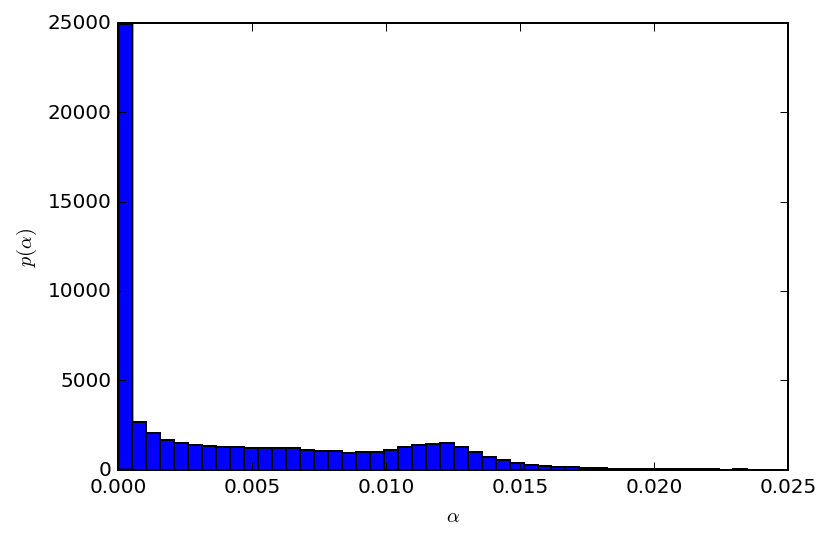

In [27]:
pu.plot_histogram_posterior(g_det_eff[:,2,2])
xlabel(r'$\alpha$')
ylabel(r'$p(\alpha)$')

The posterior on the rate is proportional to
$$
p(R | N_{pl}, \alpha) \sim R^{N_{pl}} \exp\left[ - R \sum_i \alpha_i \right]
$$

Let's grab the number of counts in the bins:

In [28]:
gkids_set = set(g_det_ids)
g_pl_counts = zeros((pbins.shape[0]-1, rbins.shape[0]-1), dtype=np.int)
noutside = 0
for pl in planets:
    if pl['kepid'] in gkids_set and pl['koi_pdisposition'] == 'CANDIDATE' and pl['koi_max_mult_ev'] >= 15:
        pind = bisect.bisect(pbins, pl['koi_period']) - 1
        rind = bisect.bisect(rbins, pl['koi_prad']) - 1
                
        if (pind < 0) or (rind < 0) or (pind >= g_pl_counts.shape[0]) or (rind >= g_pl_counts.shape[1]):
            noutside += 1
        else:
            g_pl_counts[pind, rind] += 1
print noutside, ' planets landed outside any bins!'

574  planets landed outside any bins!


In [29]:
ggammas = zeros((pbins.shape[0]-1, rbins.shape[0]-1))
ggammamins = zeros((pbins.shape[0]-1, rbins.shape[0]-1))
ggammamaxs = zeros((pbins.shape[0]-1, rbins.shape[0]-1))
for i in range(pbins.shape[0]-1):
    for j in range(rbins.shape[0]-1):
        rmed, rmin, rmax = rate_and_uncertainty(g_pl_counts[i,j], np.sum(g_det_eff[:,i,j]))
        ggammas[i,j] = rmed
        ggammamins[i,j] = rmin
        ggammamaxs[i,j] = rmax

/Users/farr/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/farr/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


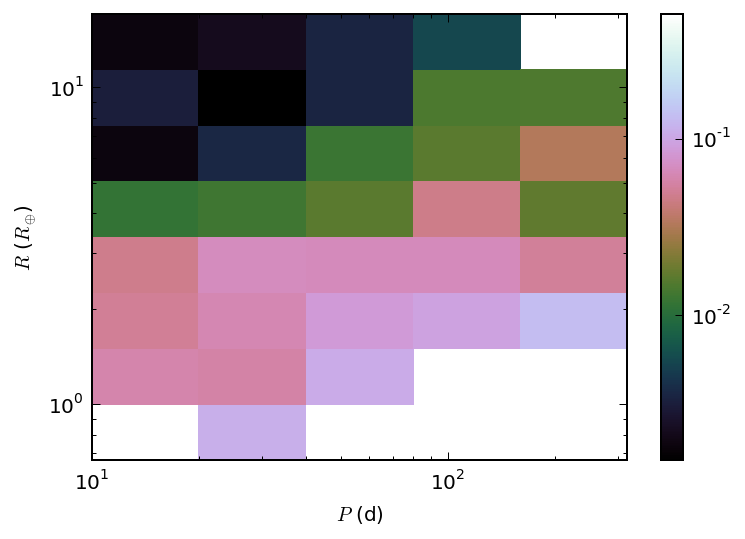

In [51]:
PS, RS = meshgrid(pbins, rbins, indexing='ij')
pcolormesh(PS, RS, ggammas, norm=LogNorm())
xscale('log')
yscale('log')
colorbar()
axis(xmin=min(pbins), xmax=max(pbins), ymin=min(rbins), ymax=max(rbins))
xlabel(r'$P$ (d)')
ylabel(r'$R$ ($R_\oplus$)')
savefig('eta_g.pdf')

In [31]:
with gzip.open('pbins.dat.gz', 'w') as out:
    savetxt(out, pbins.reshape((1,-1)))
with gzip.open('rbins.dat.gz', 'w') as out:
    savetxt(out, rbins.reshape((1, -1)))
with gzip.open('eta_g.dat.gz', 'w') as out:
    savetxt(out, ggammas)
with gzip.open('sigma_p_g.dat.gz', 'w') as out:
    savetxt(out, ggammamaxs-ggammas)
with gzip.open('sigma_n_g.dat.gz', 'w') as out:
    savetxt(out, ggammas-ggammamins)

## M-Dwarfs

Repeat the above for the M-dwarfs

In [32]:
mdata = genfromtxt(op.join(occur_dir, 'hack_week_m_dwarfs.csv'), delimiter=',', names=True)

In [94]:
with gzip.open('m-integrated-eff.dat.gz.temp', 'w') as out:
    out.write('# kepid ')
    out.write(' '.join(['(%g-%g, %g-%g)'%(plow, phigh, rlow, rhigh) \
                        for (plow, phigh) in zip(pbins[:-1], pbins[1:]) \
                        for (rlow, rhigh) in zip(rbins[:-1], rbins[1:])]))
    out.write('\n')
    for kid in mdata['kepid']:
        try:
            kid = int(round(kid))
            eff = af.open(op.join(eff_dir, 'contourV0%09d_tot.fits.gz'%kid))
            ps = exp(linspace(log(eff[0].header['MINPER']), log(eff[0].header['MAXPER']), eff[0].header['NPER']))
            rs = exp(linspace(log(eff[0].header['MINRP']), log(eff[0].header['MAXRP']), eff[0].header['NRP']))
            int_effs = []
            for plow, phigh in zip(pbins[:-1], pbins[1:]):
                for rlow, rhigh in zip(rbins[:-1], rbins[1:]):
                    int_effs.append(integrate_efficiency(ps, rs, eff[0].data.T, plow, phigh, rlow, rhigh))
            int_effs = array(int_effs)
            out.write('%09d '%kid)
            out.write(' '.join(['%g'%ie for ie in int_effs]))
            out.write('\n')
            eff.close()
        except:
            print 'Could not process KID ', kid, ' exception: ', sys.exc_info()[0]
os.rename('m-integrated-eff.dat.gz.temp', 'm-integrated-eff.dat.gz')

Could not process KID  10979716  exception:  <type 'exceptions.IOError'>
Could not process KID  2442084  exception:  <type 'exceptions.IOError'>
Could not process KID  3831911  exception:  <type 'exceptions.IOError'>
Could not process KID  5080636  exception:  <type 'exceptions.IOError'>
Could not process KID  9612825  exception:  <type 'exceptions.IOError'>
Could not process KID  9787239  exception:  <type 'exceptions.IOError'>


In [33]:
m_det_eff = loadtxt('m-integrated-eff.dat.gz')
m_det_ids = m_det_eff[:,0]
m_det_eff = m_det_eff[:,1:].reshape((-1, pbins.shape[0]-1, rbins.shape[0]-1))

We are interested in the ``(1, 2)`` bin for M-dwarfs.  What does the detection efficiency look like there?

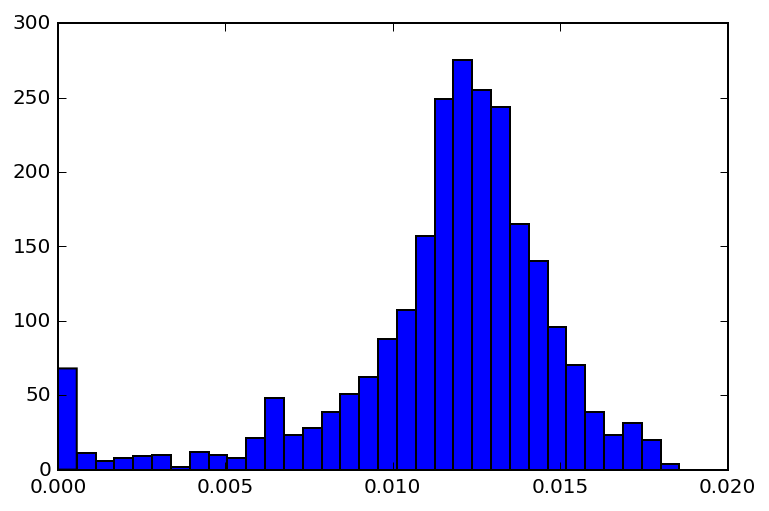

In [34]:
pu.plot_histogram_posterior(m_det_eff[:,1,2])

In [35]:
mkids_set = set(m_det_ids)
m_pl_counts = zeros((pbins.shape[0]-1, rbins.shape[0]-1), dtype=np.int)
noutside = 0
for pl in planets:
    if pl['kepid'] in mkids_set and pl['koi_pdisposition'] == 'CANDIDATE' and pl['koi_max_mult_ev'] >= 15:
        pind = bisect.bisect(pbins, pl['koi_period']) - 1
        rind = bisect.bisect(rbins, pl['koi_prad']) - 1
                
        if (pind < 0) or (rind < 0) or (pind >= m_pl_counts.shape[0]) or (rind >= m_pl_counts.shape[1]):
            noutside += 1
        else:
            m_pl_counts[pind, rind] += 1
print noutside, ' planets landed outside any bins!'

55  planets landed outside any bins!


In [36]:
mgammas = zeros((pbins.shape[0]-1, rbins.shape[0]-1))
mgammamins = zeros((pbins.shape[0]-1, rbins.shape[0]-1))
mgammamaxs = zeros((pbins.shape[0]-1, rbins.shape[0]-1))
for i in range(pbins.shape[0]-1):
    for j in range(rbins.shape[0]-1):
        rmed, rmin, rmax = rate_and_uncertainty(m_pl_counts[i,j], np.sum(m_det_eff[:,i,j]))
        mgammas[i,j] = rmed
        mgammamins[i,j] = rmin
        mgammamaxs[i,j] = rmax

/Users/farr/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/farr/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


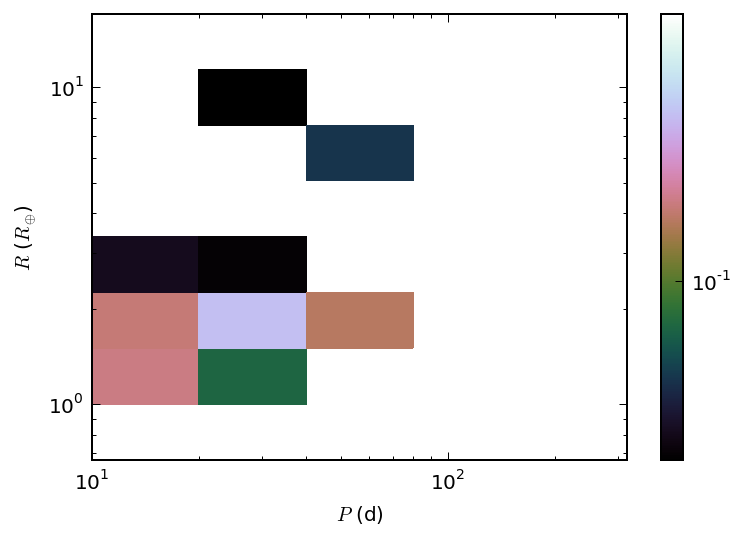

In [53]:
PS, RS = meshgrid(pbins, rbins, indexing='ij')
pcolormesh(PS, RS, mgammas, norm=LogNorm())
xscale('log')
yscale('log')
colorbar()
axis(xmin=min(pbins), xmax=max(pbins), ymin=min(rbins), ymax=max(rbins))
xlabel(r'$P$ (d)')
ylabel(r'$R$ ($R_\oplus$)')
savefig('eta_m.pdf')

In [38]:
print 'In the (1,2) bin R = ', mgammas[1,2], ' + ', (mgammamaxs[1,2]-mgammas[1,2]), ' - ', (mgammas[1,2] - mgammamins[1,2])

In the (1,2) bin R =  0.26058028095  +  0.108671343163  -  0.0849355716341


In [39]:
with gzip.open('pbins.dat.gz', 'w') as out:
    savetxt(out, pbins.reshape((1,-1)))
with gzip.open('rbins.dat.gz', 'w') as out:
    savetxt(out, rbins.reshape((1, -1)))
with gzip.open('eta_m.dat.gz', 'w') as out:
    savetxt(out, mgammas)
with gzip.open('sigma_p_m.dat.gz', 'w') as out:
    savetxt(out, mgammamaxs-mgammas)
with gzip.open('sigma_n_m.dat.gz', 'w') as out:
    savetxt(out, mgammas-mgammamins)

## And Finally for K-Dwarfs

In [40]:
kdata = genfromtxt(op.join(occur_dir, 'hack_week_k_dwarfs.csv'), delimiter=',', names=True)

In [113]:
with gzip.open('k-integrated-eff.dat.gz.temp', 'w') as out:
    out.write('# kepid ')
    out.write(' '.join(['(%g-%g, %g-%g)'%(plow, phigh, rlow, rhigh) \
                        for (plow, phigh) in zip(pbins[:-1], pbins[1:]) \
                        for (rlow, rhigh) in zip(rbins[:-1], rbins[1:])]))
    out.write('\n')
    for kid in kdata['kepid']:
        try:
            kid = int(round(kid))
            eff = af.open(op.join(eff_dir, 'contourV0%09d_tot.fits.gz'%kid))
            ps = exp(linspace(log(eff[0].header['MINPER']), log(eff[0].header['MAXPER']), eff[0].header['NPER']))
            rs = exp(linspace(log(eff[0].header['MINRP']), log(eff[0].header['MAXRP']), eff[0].header['NRP']))
            int_effs = []
            for plow, phigh in zip(pbins[:-1], pbins[1:]):
                for rlow, rhigh in zip(rbins[:-1], rbins[1:]):
                    int_effs.append(integrate_efficiency(ps, rs, eff[0].data.T, plow, phigh, rlow, rhigh))
            int_effs = array(int_effs)
            out.write('%09d '%kid)
            out.write(' '.join(['%g'%ie for ie in int_effs]))
            out.write('\n')
            eff.close()
        except:
            print 'Could not process KID ', kid, ' exception: ', sys.exc_info()[0]
os.rename('k-integrated-eff.dat.gz.temp', 'k-integrated-eff.dat.gz')

Could not process KID  10129482  exception:  <type 'exceptions.IOError'>
Could not process KID  10189523  exception:  <type 'exceptions.IOError'>
Could not process KID  10162509  exception:  <type 'exceptions.IOError'>
Could not process KID  10735988  exception:  <type 'exceptions.IOError'>
Could not process KID  10751515  exception:  <type 'exceptions.IOError'>
Could not process KID  10613718  exception:  <type 'exceptions.IOError'>
Could not process KID  10556578  exception:  <type 'exceptions.IOError'>
Could not process KID  11076176  exception:  <type 'exceptions.IOError'>
Could not process KID  10936427  exception:  <type 'exceptions.IOError'>
Could not process KID  11303811  exception:  <type 'exceptions.IOError'>
Could not process KID  11404698  exception:  <type 'exceptions.IOError'>
Could not process KID  11455795  exception:  <type 'exceptions.IOError'>
Could not process KID  11235323  exception:  <type 'exceptions.IOError'>
Could not process KID  11706658  exception:  <type 

In [41]:
k_det_eff = loadtxt('k-integrated-eff.dat.gz')
k_det_ids = k_det_eff[:,0]
k_det_eff = k_det_eff[:,1:].reshape((-1, pbins.shape[0]-1, rbins.shape[0]-1))

In [42]:
kkids_set = set(k_det_ids)
k_pl_counts = zeros((pbins.shape[0]-1, rbins.shape[0]-1), dtype=np.int)
noutside = 0
for pl in planets:
    if pl['kepid'] in kkids_set and pl['koi_pdisposition'] == 'CANDIDATE' and pl['koi_max_mult_ev'] >= 15:
        pind = bisect.bisect(pbins, pl['koi_period']) - 1
        rind = bisect.bisect(rbins, pl['koi_prad']) - 1
                
        if (pind < 0) or (rind < 0) or (pind >= k_pl_counts.shape[0]) or (rind >= k_pl_counts.shape[1]):
            noutside += 1
        else:
            k_pl_counts[pind, rind] += 1
print noutside, ' planets landed outside any bins!'

326  planets landed outside any bins!


In [43]:
kgammas = zeros((pbins.shape[0]-1, rbins.shape[0]-1))
kgammamins = zeros((pbins.shape[0]-1, rbins.shape[0]-1))
kgammamaxs = zeros((pbins.shape[0]-1, rbins.shape[0]-1))
for i in range(pbins.shape[0]-1):
    for j in range(rbins.shape[0]-1):
        rmed, rmin, rmax = rate_and_uncertainty(k_pl_counts[i,j], np.sum(k_det_eff[:,i,j]))
        kgammas[i,j] = rmed
        kgammamins[i,j] = rmin
        kgammamaxs[i,j] = rmax

/Users/farr/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/Users/farr/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


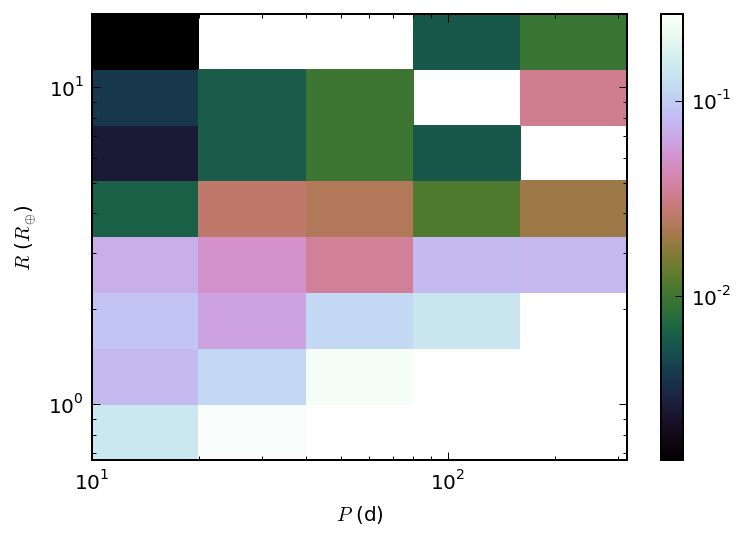

In [52]:
PS, RS = meshgrid(pbins, rbins, indexing='ij')
pcolormesh(PS, RS, kgammas, norm=LogNorm())
xscale('log')
yscale('log')
colorbar()
axis(xmin=min(pbins), xmax=max(pbins), ymin=min(rbins), ymax=max(rbins))
xlabel(r'$P$ (d)')
ylabel(r'$R$ ($R_\oplus$)')
savefig('eta_k.pdf')

In [45]:
print 'In K-star bin (40-80, 1.5-2.25)', kgammas[2, 2], ' + ', (kgammamaxs[2,2]-kgammas[2,2]), ' - ', (kgammas[2,2]-kgammamins[2,2])
print 'In K-star bin (20-40, 1.5-2.25)', kgammas[1, 2], ' + ', (kgammamaxs[1,2]-kgammas[1,2]), ' - ', (kgammas[1,2]-kgammamins[1,2])

In K-star bin (40-80, 1.5-2.25) 0.117594663788  +  0.035129773173  -  0.0293198491482
In K-star bin (20-40, 1.5-2.25) 0.0613618599911  +  0.0164269001959  -  0.0139280992402


In [46]:
with gzip.open('pbins.dat.gz', 'w') as out:
    savetxt(out, pbins.reshape((1,-1)))
with gzip.open('rbins.dat.gz', 'w') as out:
    savetxt(out, rbins.reshape((1, -1)))
with gzip.open('eta_k.dat.gz', 'w') as out:
    savetxt(out, kgammas)
with gzip.open('sigma_p_k.dat.gz', 'w') as out:
    savetxt(out, kgammamaxs-kgammas)
with gzip.open('sigma_n_k.dat.gz', 'w') as out:
    savetxt(out, kgammas-kgammamins)